In [1]:
import os 
import pandas as pd
import numpy as np

In [2]:
next(os.walk('.'))[1]

['.ipynb_checkpoints', 'turku-ner-corpus']

In [3]:
# Test if tensorflow has access to GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\perhe\Miniconda3\envs\NLPCourse\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\perhe\Miniconda3\envs\NLPCourse\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\perhe\Miniconda3\envs\NLPCourse\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\perhe\Miniconda3\envs\NLPCourse\lib\site-packages

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16801544846930107588
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3154483609
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1150077492823011657
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


### Read data and format

The data is given in a .tsv format, which for some reason did not read nicely into pandas, so the following section is to read the data into a dataframe with sentenceID's (incremented) so we can easily access them as we wish. 

In [4]:
# A hack function to increment sentenceID's in the dataframe
def sentenceID(row: pd.Series) -> int:
    global count
    
    if pd.isna(row[1]):
        count += 1
        return count
    else:
        return count 
    
def dataframe_from_tsv(lines: [str]) -> pd.DataFrame:
    train = pd.DataFrame(lines)                                                 # Create a dataframe for easier manipulation 
    train = train.drop(columns=[1])                                             # Drop the empty column
    df = train[0].str.split('\t', expand=True)                                  # Split by tab 
    df.columns = ["Tokens", "Entities"]                                         # Name columns 
    df['SentenceId'] = pd.Series('', index=[n for n in range(df.shape[0])])     # Append sentence column 
    df['SentenceId'] = df.apply(lambda row: sentenceID(row), axis=1)            # Append sentenceId by counts 
    df = df[~pd.isna(df['Entities'])]                                           # Drop empty rows 
    return df

In [5]:
with open('turku-ner-corpus/combined-extended/train.tsv', encoding='UTF-8') as file: 
    train_lines = [line.split('\n') for line in file]
    
with open('turku-ner-corpus/combined-extended/dev.tsv', encoding='UTF-8') as file:
    val_lines = [line.split('\n') for line in file]

In [6]:
count = 0
df_train = dataframe_from_tsv(train_lines)
print(df_train.head())

count = 0
df_test = dataframe_from_tsv(val_lines)
print(df_test.head())

         Tokens Entities  SentenceId
0  Kävelyreitti        O           0
1           III        O           0
3        Jäällä        O           1
4        kävely        O           1
5          avaa        O           1
       Tokens Entities  SentenceId
0     Pelkkää        O           0
1   tyhjyyttä        O           0
3       Kävin        O           1
4      tänään   B-DATE           1
5  katsomassa        O           1


In [7]:
df_test.head(10)

,Tokens,Entities,SentenceId
0,Pelkkää,O,0
1,tyhjyyttä,O,0
3,Kävin,O,1
4,tänään,B-DATE,1
5,katsomassa,O,1
6,Suomen,B-ORG,1
7,Perinteisen,I-ORG,1
8,Teatterin,I-ORG,1
9,näytelmän,O,1
10,Ranta,B-WORK_OF_ART,1


In [8]:
def unpack_df(df: pd.DataFrame) -> (list, list): 
    texts = []
    labels = []
    for sent_id in range(max(df['SentenceId'].unique())):
        temp_df = df.query(f"SentenceId == {sent_id}")
        texts.append(temp_df['Tokens'].tolist())
        labels.append(temp_df['Entities'].tolist())
    return texts, labels

In [9]:
# Initially in same format as in the course example
train_texts, train_labels = unpack_df(df_train)
validation_texts, validation_labels = unpack_df(df_test)

In [10]:
print("=====================")
print("====== TRAIN ========")
print("=====================")
# Sanity check. 
for n in range(5):
    print('Text:', train_texts[n])
    print('Label:', train_labels[n])
print("=====================")
print("==== VALIDATION =====")
print("=====================")
# Sanity check. 
for n in range(5):
    print('Text:', validation_texts[n])
    print('Label:', validation_labels[n])

====== TRAIN ========
Text: ['Kävelyreitti', 'III']
Label: ['O', 'O']
Text: ['Jäällä', 'kävely', 'avaa', 'aina', 'hauskoja', 'ja', 'erikoisia', 'näkökulmia', 'kaupunkiin', '.']
Label: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Text: ['Vähän', 'samanlainen', 'tunne', 'kuin', 'silloin', ',', 'kun', 'ystävämme', 'vei', 'meidät', 'kerran', 'ylös', 'tuomiokirkon', 'torniin', '.']
Label: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Text: ['Kuinka', 'erilaiselta', 'maailma', 'sieltä', 'näyttikään', '.']
Label: ['O', 'O', 'O', 'O', 'O', 'O']
Text: ['Vaikka', 'tiesi', ',', 'millainen', 'Turku', 'on', 'kartalla', ',', 'se', 'hämmästytti', 'siltikin', '.']
Label: ['O', 'O', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
==== VALIDATION =====
Text: ['Pelkkää', 'tyhjyyttä']
Label: ['O', 'O']
Text: ['Kävin', 'tänään', 'katsomassa', 'Suomen', 'Perinteisen', 'Teatterin', 'näytelmän', 'Ranta', '.']
Label: ['O', 'B-DATE', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O',

### Load the word embeddings 

The following is mainly taken from the course material, except that the .vec file (for finnish word embeddings) is downloaded from fastText. 

In [11]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("cc.fi.300.vec", binary=False, limit=50000)

# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

Words from embedding model: 50000
First 50 words: ['.', ',', 'ja', '</s>', 'on', ':', '"', ')', '(', '/', "'", 'oli', 'ei', '–', 'että', '-', 'myös', '1', '!', 'tai', 'Lisätiedot', '?', 'ovat', 'mutta', 'joka', 'se', 'sekä', 'n', 'vuonna', '#', '2', '%', 'kun', 'hän', 'sen', 'ole', 'kuin', 'niin', '”', 'kanssa', 'voi', '...', '+', '3', '&', 'kello', 'Hän', 'mukaan', 'jälkeen', 'klo']


In [12]:
# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("ja")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("ja")[:10])

Before normalization: [ 0.0686  0.0713 -0.0378 -0.1222 -0.0428 -0.1847  0.0278 -0.0429  0.4505
 -0.008 ]
After normalization: [ 0.04610316  0.04791772 -0.02540378 -0.08212546 -0.02876407 -0.12412907
  0.01868321 -0.02883128  0.30276206 -0.00537646]


##### Todo: check the following code carefully -- does not necessarily work one-to-one from course example 

In [13]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
# Loads word embeddings into an array. 
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = np.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = np.vstack((np.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


In [14]:
from pprint import pprint

# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences
    for label in sentence_labels: #loops over labels in one sentence
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-DATE': 30,
 'B-EVENT': 17,
 'B-FAC': 14,
 'B-GPE': 21,
 'B-LANGUAGE': 29,
 'B-LAW': 26,
 'B-LOC': 12,
 'B-MONEY': 22,
 'B-NORP': 24,
 'B-ORG': 3,
 'B-PERCENT': 25,
 'B-PERSON': 23,
 'B-PRODUCT': 8,
 'B-QUANTITY': 31,
 'B-TIME': 32,
 'B-WORK_OF_ART': 7,
 'I-DATE': 27,
 'I-EVENT': 4,
 'I-FAC': 5,
 'I-GPE': 16,
 'I-LANGUAGE': 19,
 'I-LAW': 0,
 'I-LOC': 11,
 'I-MONEY': 18,
 'I-NORP': 2,
 'I-ORG': 20,
 'I-PERCENT': 1,
 'I-PERSON': 6,
 'I-PRODUCT': 9,
 'I-QUANTITY': 15,
 'I-TIME': 28,
 'I-WORK_OF_ART': 13,
 'O': 10}


In [15]:
# vectorize the labels
def label_vectorizer(labels,label_map):
    vectorized_labels = []
    for label in labels:
        vectorized_example_label = []
        for token in label:
            vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = np.array(vectorized_labels)
    return vectorized_labels
        
vectorized_labels = label_vectorizer(train_labels, label_map)
validation_vectorized_labels = label_vectorizer(validation_labels, label_map)

pprint(vectorized_labels[0])

[10, 10]


In [16]:
def text_vectorizer(vocab, texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = np.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, validation_texts)

sent = 0
print(train_texts[sent])
print(vectorized_data[sent])
print([inv_vocabulary[i] for i in vectorized_data[sent]])

['Kävelyreitti', 'III']
[1, 922]
['<OOV>', 'III']


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post', maxlen=max(lengths))
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])

# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=np.expand_dims(pad_sequences(vectorized_labels, padding='post', maxlen=max(lengths)), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
pprint(label_map)
print("First example labels:")
pprint(vectorized_labels_padded[0])

weights = np.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:", weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='post', maxlen=max(lengths))
validation_vectorized_labels_padded=np.expand_dims(pad_sequences(validation_vectorized_labels, padding='post',maxlen=max(lengths)), -1)
validation_weights = np.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

Old shape: (27832,)
New shape: (27832, 274)
First example: [  1 922   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [18]:
from tensorflow import keras


def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets


def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             


def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore


class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = np.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from tensorflow.keras.optimizers import SGD, Adam


example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]


def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="relu"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [63]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 274)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 274, 300)          15000600  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 274, 100)          30100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 274, 33)           3333      
Total params: 15,034,033
Trainable params: 33,433
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [64]:
optimizer = Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model.fit(
    vectorized_data_padded,
    vectorized_labels_padded,
    sample_weight=weights,
    batch_size=100,
    verbose=2,
    epochs=10,
    callbacks=[evaluation_function]
)

Epoch 1/10

Precision/Recall/F-score: 0.467843631778058 / 0.1727992547741034 / 0.2523809523809524
 - 5s - loss: 1.0672
Epoch 2/10

Precision/Recall/F-score: 0.49341842840047867 / 0.28807638565440147 / 0.36377003381855616
 - 3s - loss: 0.5254
Epoch 3/10

Precision/Recall/F-score: 0.5017103762827823 / 0.3074056823474616 / 0.3812274368231047
 - 3s - loss: 0.4791
Epoch 4/10

Precision/Recall/F-score: 0.5063752276867031 / 0.32370749883558453 / 0.39494246341809913
 - 3s - loss: 0.4603
Epoch 5/10

Precision/Recall/F-score: 0.5162314749470712 / 0.3407079646017699 / 0.41049382716049376
 - 3s - loss: 0.4503
Epoch 6/10

Precision/Recall/F-score: 0.5190053285968028 / 0.34024219841639497 / 0.41102827401884934
 - 3s - loss: 0.4443
Epoch 7/10

Precision/Recall/F-score: 0.5177824267782427 / 0.3458313926408943 / 0.41468863445964815
 - 3s - loss: 0.4398
Epoch 8/10

Precision/Recall/F-score: 0.5298747763864043 / 0.3448998602701444 / 0.4178304415291297
 - 3s - loss: 0.4361
Epoch 9/10

Precision/Recall/F-s

No handles with labels found to put in legend.


History: [0.2523809523809524, 0.36377003381855616, 0.3812274368231047, 0.39494246341809913, 0.41049382716049376, 0.41102827401884934, 0.41468863445964815, 0.4178304415291297, 0.41835016835016836, 0.4166316673666527]
Highest f-score: 0.41835016835016836


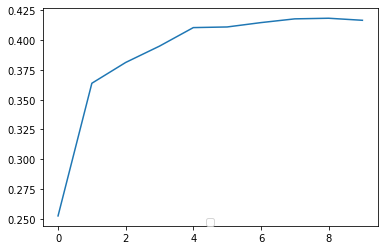

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores):
    print("History:", fscores)
    print("Highest f-score:", max(fscores))
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()


plot_history(evaluation_function.fscore)

### RNN Model 

In [80]:
from tensorflow.keras.layers import LSTM, GRU


example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 100

vector_size= pretrained.shape[1]


def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    rnn = GRU(rnn_size, activation='relu', return_sequences=True)(embeddings)
    #rnn = LSTM(rnn_size, activation='relu', return_sequences=True)(embeddings)
    outp = Dense(class_count, activation="softmax")(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 274)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 274, 300)          15000600  
_________________________________________________________________
gru_3 (GRU)                  (None, 274, 100)          120300    
_________________________________________________________________
dense_11 (Dense)             (None, 274, 33)           3333      
Total params: 15,124,233
Trainable params: 123,633
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [81]:
optimizer=Adam(lr=0.001) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10

Precision/Recall/F-score: 0.4129277566539924 / 0.1264555193292967 / 0.19361740060616867
 - 191s - loss: 1.0585
Epoch 2/10

Precision/Recall/F-score: 0.5717703349282297 / 0.3896134140661388 / 0.4634349030470914
 - 184s - loss: 0.4639
Epoch 3/10

Precision/Recall/F-score: 0.6216393442622951 / 0.4415463437354448 / 0.5163398692810457
 - 184s - loss: 0.3756
Epoch 4/10

Precision/Recall/F-score: 0.6650132275132276 / 0.468327899394504 / 0.5496037168625307
 - 182s - loss: 0.3401
Epoch 5/10

Precision/Recall/F-score: 0.6905396402398402 / 0.48276665114112716 / 0.5682565789473685
 - 190s - loss: 0.3202
Epoch 6/10

Precision/Recall/F-score: 0.6863905325443787 / 0.5132743362831859 / 0.5873417721518988
 - 176s - loss: 0.3053
Epoch 7/10

Precision/Recall/F-score: 0.6988294843403986 / 0.5144387517466232 / 0.5926224010731054
 - 173s - loss: 0.2946
Epoch 8/10

Precision/Recall/F-score: 0.6959975557592423 / 0.5305076851420587 / 0.6020880137438879
 - 176s - loss: 0.2850
Epoch 9/10

Precision/R

No handles with labels found to put in legend.


History: [0.19361740060616867, 0.4634349030470914, 0.5163398692810457, 0.5496037168625307, 0.5682565789473685, 0.5873417721518988, 0.5926224010731054, 0.6020880137438879, 0.6027657266811279, 0.6142652981681175]
Highest f-score: 0.6142652981681175


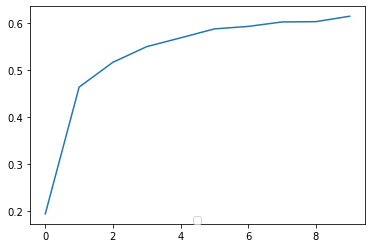

In [82]:
plot_history(evaluation_function.fscore)

In [84]:
from tensorflow.keras.models import load_model

model.save('gru_lr_0.001_catcrossentropy_f_0.614.h5')

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')